# Credit Risk Resampling Techniques

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

# Read the CSV and Perform Basic Data Cleaning

In [3]:
columns = [
    "loan_amnt", "int_rate", "installment", "home_ownership",
    "annual_inc", "verification_status", "issue_d", "loan_status",
    "pymnt_plan", "dti", "delinq_2yrs", "inq_last_6mths",
    "open_acc", "pub_rec", "revol_bal", "total_acc",
    "initial_list_status", "out_prncp", "out_prncp_inv", "total_pymnt",
    "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee",
    "recoveries", "collection_recovery_fee", "last_pymnt_amnt", "next_pymnt_d",
    "collections_12_mths_ex_med", "policy_code", "application_type", "acc_now_delinq",
    "tot_coll_amt", "tot_cur_bal", "open_acc_6m", "open_act_il",
    "open_il_12m", "open_il_24m", "mths_since_rcnt_il", "total_bal_il",
    "il_util", "open_rv_12m", "open_rv_24m", "max_bal_bc",
    "all_util", "total_rev_hi_lim", "inq_fi", "total_cu_tl",
    "inq_last_12m", "acc_open_past_24mths", "avg_cur_bal", "bc_open_to_buy",
    "bc_util", "chargeoff_within_12_mths", "delinq_amnt", "mo_sin_old_il_acct",
    "mo_sin_old_rev_tl_op", "mo_sin_rcnt_rev_tl_op", "mo_sin_rcnt_tl", "mort_acc",
    "mths_since_recent_bc", "mths_since_recent_inq", "num_accts_ever_120_pd", "num_actv_bc_tl",
    "num_actv_rev_tl", "num_bc_sats", "num_bc_tl", "num_il_tl",
    "num_op_rev_tl", "num_rev_accts", "num_rev_tl_bal_gt_0",
    "num_sats", "num_tl_120dpd_2m", "num_tl_30dpd", "num_tl_90g_dpd_24m",
    "num_tl_op_past_12m", "pct_tl_nvr_dlq", "percent_bc_gt_75", "pub_rec_bankruptcies",
    "tax_liens", "tot_hi_cred_lim", "total_bal_ex_mort", "total_bc_limit",
    "total_il_high_credit_limit", "hardship_flag", "debt_settlement_flag"
]

target = ["loan_status"]

In [4]:
# Load the data
file_path = Path('LoanStats_2019Q1.csv')
df = pd.read_csv(file_path, skiprows=1)[:-2]
df = df.loc[:, columns].copy()

# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')

# Drop the null rows
df = df.dropna()

# Remove the `Issued` loan status
issued_mask = df['loan_status'] != 'Issued'
df = df.loc[issued_mask]

# convert interest rate to numerical
df['int_rate'] = df['int_rate'].str.replace('%', '')
df['int_rate'] = df['int_rate'].astype('float') / 100


# Convert the target column values to low_risk and high_risk based on their values
x = {'Current': 'low_risk'}   
df = df.replace(x)

x = dict.fromkeys(['Late (31-120 days)', 'Late (16-30 days)', 'Default', 'In Grace Period'], 'high_risk')    
df = df.replace(x)

df.reset_index(inplace=True, drop=True)

df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


In [5]:
print ("There are {} numeric and {} categorical columns in the dataset".format(df.select_dtypes(include=[np.number]).shape[1],df.select_dtypes(exclude=[np.number]).shape[1]))

There are 76 numeric and 10 categorical columns in the dataset


# Split the Data into Training and Testing

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68817 entries, 0 to 68816
Data columns (total 86 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   loan_amnt                   68817 non-null  float64
 1   int_rate                    68817 non-null  float64
 2   installment                 68817 non-null  float64
 3   home_ownership              68817 non-null  object 
 4   annual_inc                  68817 non-null  float64
 5   verification_status         68817 non-null  object 
 6   issue_d                     68817 non-null  object 
 7   loan_status                 68817 non-null  object 
 8   pymnt_plan                  68817 non-null  object 
 9   dti                         68817 non-null  float64
 10  delinq_2yrs                 68817 non-null  float64
 11  inq_last_6mths              68817 non-null  float64
 12  open_acc                    68817 non-null  float64
 13  pub_rec                     688

In [7]:
#  Data Size. There are 66,817 data point and 86 columns.
df.shape

(68817, 86)

In [8]:
# #Create numeric plots
# from pylab import savefig
# import seaborn as ss
# num_pic = [f for f in df.columns if df.dtypes[f] != 'object']
# num = pd.melt(df, value_vars = num_pic)
# n_p = ss.FacetGrid (num, col='variable', col_wrap=10, sharex=False, sharey = False)
# n_p.map(ss.distplot, 'value');
# n_p.savefig('numerical_plots.png', dpi=400)


In [9]:
# Create our features. 
#  Convert string columns to numbers using pd.getdummies (it converts categorical data into dummy or indicator variables)
#  There are 9 columns that are strings
#  And drop "loan status"
X = pd.get_dummies(df, columns=['home_ownership', 'verification_status', 'issue_d', 'pymnt_plan', 
                'initial_list_status', 'next_pymnt_d', 'application_type', 'hardship_flag', 
                'debt_settlement_flag'])
X = X.drop("loan_status", axis=1)

# Create our target y
y = df['loan_status']
X.head()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,issue_d_Mar-2019,pymnt_plan_n,initial_list_status_f,initial_list_status_w,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019,application_type_Individual,application_type_Joint App,hardship_flag_N,debt_settlement_flag_N
0,10500.0,0.1719,375.35,66000.0,27.24,0.0,0.0,8.0,0.0,1609.0,...,1,1,0,1,0,1,1,0,1,1
1,25000.0,0.2000,929.09,105000.0,20.23,0.0,0.0,17.0,1.0,18368.0,...,1,1,0,1,0,1,1,0,1,1
2,20000.0,0.2000,529.88,56000.0,24.26,0.0,0.0,8.0,0.0,13247.0,...,1,1,0,1,0,1,1,0,1,1
3,10000.0,0.1640,353.55,92000.0,31.44,0.0,1.0,10.0,1.0,17996.0,...,1,1,0,1,0,1,1,0,1,1
4,22000.0,0.1474,520.39,52000.0,18.76,0.0,1.0,14.0,0.0,9091.0,...,1,1,0,1,0,1,1,0,1,1


In [10]:
X.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,issue_d_Mar-2019,pymnt_plan_n,initial_list_status_f,initial_list_status_w,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019,application_type_Individual,application_type_Joint App,hardship_flag_N,debt_settlement_flag_N
count,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,...,68817.000000,68817.0,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.0,68817.0
mean,16677.594562,0.127718,480.652863,8.821371e+04,21.778153,0.217766,0.497697,12.587340,0.126030,17604.142828,...,0.177238,1.0,0.123879,0.876121,0.383161,0.616839,0.860340,0.139660,1.0,1.0
std,10277.348590,0.048130,288.062432,1.155800e+05,20.199244,0.718367,0.758122,6.022869,0.336797,21835.880400,...,0.381873,0.0,0.329446,0.329446,0.486161,0.486161,0.346637,0.346637,0.0,0.0
min,1000.000000,0.060000,30.890000,4.000000e+01,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0
25%,9000.000000,0.088100,265.730000,5.000000e+04,13.890000,0.000000,0.000000,8.000000,0.000000,6293.000000,...,0.000000,1.0,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.0,1.0
50%,15000.000000,0.118000,404.560000,7.300000e+04,19.760000,0.000000,0.000000,11.000000,0.000000,12068.000000,...,0.000000,1.0,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.0,1.0
75%,24000.000000,0.155700,648.100000,1.040000e+05,26.660000,0.000000,1.000000,16.000000,0.000000,21735.000000,...,0.000000,1.0,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.0,1.0
max,40000.000000,0.308400,1676.230000,8.797500e+06,999.000000,18.000000,5.000000,72.000000,4.000000,587191.000000,...,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0


In [11]:
# Check the balance of our target values
y.value_counts()

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from collections import Counter

In [13]:
#  Create the target variables. 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
Counter(y_train)

Counter({'low_risk': 51366, 'high_risk': 246})

In [14]:
Counter(y_test)

Counter({'low_risk': 17104, 'high_risk': 101})

In [15]:
y_train_base = pd.Series(len(y_train))
y_train_base

0    51612
dtype: int64

In [16]:
y_test_base = pd.Series(len(y_test))
y_test_base

0    17205
dtype: int64

# Oversampling

In this section, you will compare two oversampling algorithms to determine which algorithm results in the best performance. You will oversample the data using the naive random oversampling algorithm and the SMOTE algorithm. For each algorithm, be sure to complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

### Naive Random Oversampling

In [17]:
# Resample the training data with the RandomOversampler
# On the train dataset: The high_risk (246) is much smaller than the low_risk (51,366). Hence there is a data imbalance.  
# To get a better balance we will generate syntethic samples of the minority class  

# Import RandonOverSampler
from imblearn.over_sampling import RandomOverSampler

# Set up model "ros = RandonOverSampler"
ros = RandomOverSampler(random_state=1)

# Resample the targets
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

Counter(y_resampled)

Counter({'low_risk': 51366, 'high_risk': 51366})

In [18]:
# Train the Logistic Regression model using the resampled data
from sklearn.linear_model import LogisticRegression

model_log = LogisticRegression(solver='lbfgs', random_state=1)
model_log.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [19]:
# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score
y_pred = model_log.predict(X_test)
acc_score = balanced_accuracy_score(y_test, y_pred)

In [20]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

# Create df for confusion matrix
cm_df = pd.DataFrame(
    cm, index=["Actual High Risk", "Actual Low Risk"], columns=["Predicted High Risk", "Predicted Low Risk"])
cm_df.to_csv('conf_matrix_Random.csv')
# Displaying results
print("Oversampling Analysis - Confusion Matrix")
display(cm_df)

Oversampling Analysis - Confusion Matrix


,Predicted High Risk,Predicted Low Risk
Actual High Risk,70,31
Actual Low Risk,6080,11024


In [21]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced

# Displaying results
print("RandomOverSampler Analysis - Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report - RandomOverSampler")
print(classification_report_imbalanced(y_test, y_pred))

RandomOverSampler Analysis - Confusion Matrix


,Predicted High Risk,Predicted Low Risk
Actual High Risk,70,31
Actual Low Risk,6080,11024


Accuracy Score : 0.6687984514073484
Classification Report - RandomOverSampler
                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.01      0.69      0.64      0.02      0.67      0.45       101
   low_risk       1.00      0.64      0.69      0.78      0.67      0.44     17104

avg / total       0.99      0.64      0.69      0.78      0.67      0.44     17205



In [22]:
# Print the imbalanced classification report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
print('RandomOverSampler')
print('f1-score: ',f1_score(y_test, y_pred, average='weighted'))
print('precision score: ',precision_score(y_test, y_pred, average="weighted"))
print('recall score: ',recall_score(y_test, y_pred, average="weighted"))    

RandomOverSampler
f1-score:  0.7785174168166782
precision score:  0.9914087313878288
recall score:  0.6448125544899739


### SMOTE Oversampling

In [23]:
# Resample the training data with SMOTE
from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE(random_state=1, sampling_strategy='auto').fit_resample(
    X_train, y_train
)
Counter(y_resampled)

Counter({'low_risk': 51366, 'high_risk': 51366})

In [24]:
# Train the Logistic Regression model using the resampled data
model_smote = LogisticRegression(solver='lbfgs', random_state=1)
model_smote.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [25]:
# Calculated the balanced accuracy score
y_pred = model_smote.predict(X_test)
acc_score = balanced_accuracy_score(y_test, y_pred)

In [26]:
# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create df for confusion matrix
cm_df = pd.DataFrame(
    cm, index=["Actual High Risk", "Actual Low Risk"], columns=["Predicted High Risk", "Predicted Low Risk"])
cm_df.to_csv('conf_matrix_SMOTE.csv')
cm_df

,Predicted High Risk,Predicted Low Risk
Actual High Risk,64,37
Actual Low Risk,5247,11857


In [27]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced

# Displaying results
print("SMOTE Analysis")
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report - SMOTE")
print(classification_report_imbalanced(y_test, y_pred))

SMOTE Analysis
Confusion Matrix


,Predicted High Risk,Predicted Low Risk
Actual High Risk,64,37
Actual Low Risk,5247,11857


Accuracy Score : 0.6634465101093833
Classification Report - SMOTE
                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.01      0.63      0.69      0.02      0.66      0.44       101
   low_risk       1.00      0.69      0.63      0.82      0.66      0.44     17104

avg / total       0.99      0.69      0.63      0.81      0.66      0.44     17205



In [28]:
print('SMOTE')
print('f1-score: ',f1_score(y_test, y_pred, average='weighted'))
print('precision score: ',precision_score(y_test, y_pred, average="weighted"))
print('recall score: ',recall_score(y_test, y_pred, average="weighted"))    

SMOTE
f1-score:  0.8131186901202837
precision score:  0.9911078038456478
recall score:  0.6928799767509445


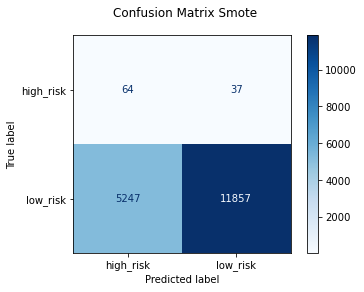

In [29]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix


disp = plot_confusion_matrix(model_smote,X_test,y_test,cmap=plt.cm.Blues)
disp.figure_.suptitle('Confusion Matrix Smote')
plt.show()

# Undersampling

In this section, you will test an undersampling algorithms to determine which algorithm results in the best performance compared to the oversampling algorithms above. You will undersample the data using the Cluster Centroids algorithm and complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [30]:
# Resample the data using the ClusterCentroids resampler
# Warning: This is a large dataset, and this step may take some time to complete
from imblearn.under_sampling import ClusterCentroids
cc = ClusterCentroids(random_state=1)
X_resampled, y_resampled = cc.fit_resample(X_train, y_train)
Counter(y_resampled)

Counter({'high_risk': 246, 'low_risk': 246})

In [31]:
# Train the Logistic Regression model using the resampled data
model_under = LogisticRegression(solver='lbfgs', random_state=1)
model_under.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [32]:
# Calculated the balanced accuracy score
y_pred = model_under.predict(X_test)
acc_score = balanced_accuracy_score(y_test, y_pred)

In [33]:
# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create df for confusion matrix
cm_df = pd.DataFrame(
    cm, index=["Actual High Risk", "Actual Low Risk"], columns=["Predicted High Risk", "Predicted Low Risk"])
cm_df.to_csv('conf_matrix_under.csv')
cm_df

,Predicted High Risk,Predicted Low Risk
Actual High Risk,70,31
Actual Low Risk,10340,6764


In [34]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced

# Displaying results
print("Undersampling Analysis")
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report - Undersampling")
print(classification_report_imbalanced(y_test, y_pred))

Undersampling Analysis
Confusion Matrix


,Predicted High Risk,Predicted Low Risk
Actual High Risk,70,31
Actual Low Risk,10340,6764


Accuracy Score : 0.5442661782548694
Classification Report - Undersampling
                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.01      0.69      0.40      0.01      0.52      0.28       101
   low_risk       1.00      0.40      0.69      0.57      0.52      0.27     17104

avg / total       0.99      0.40      0.69      0.56      0.52      0.27     17205



In [35]:
print('UnderSampling')
print('f1-score: ',f1_score(y_test, y_pred, average='weighted'))
print('precision score: ',precision_score(y_test, y_pred, average="weighted"))
print('recall score: ',recall_score(y_test, y_pred, average="weighted"))    

UnderSampling
f1-score:  0.56280405338317
precision score:  0.9896336914218877
recall score:  0.3972101133391456


# Combination (Over and Under) Sampling

In this section, you will test a combination over- and under-sampling algorithm to determine if the algorithm results in the best performance compared to the other sampling algorithms above. You will resample the data using the SMOTEENN algorithm and complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [36]:
# Resample the training data with SMOTEENN
# Warning: This is a large dataset, and this step may take some time to complete
from imblearn.combine import SMOTEENN

smote_enn = SMOTEENN(random_state=1)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)
Counter(y_resampled)

Counter({'high_risk': 68458, 'low_risk': 62022})

In [37]:
# Train the Logistic Regression model using the resampled data
from sklearn.linear_model import LogisticRegression
model_combo = LogisticRegression(solver='lbfgs', random_state=1)
model_combo.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [38]:
# Calculated the balanced accuracy score
y_pred = model_combo.predict(X_test)
acc_score = balanced_accuracy_score(y_test, y_pred)

In [39]:
# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create df for confusion matrix
cm_df = pd.DataFrame(
    cm, index=["Actual High Risk", "Actual Low Risk"], columns=["Predicted High Risk", "Predicted Low Risk"])
cm_df.to_csv('conf_matrix_over_under.csv')
cm_df

,Predicted High Risk,Predicted Low Risk
Actual High Risk,80,21
Actual Low Risk,7478,9626


In [40]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced

# Displaying results
print("SMOTEENN Analysis")
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score SMOTEEN: {acc_score}")
print("Classification Report - Combo Over and Under Sampling")
print(classification_report_imbalanced(y_test, y_pred))

SMOTEENN Analysis
Confusion Matrix


,Predicted High Risk,Predicted Low Risk
Actual High Risk,80,21
Actual Low Risk,7478,9626


Accuracy Score SMOTEEN: 0.6774357686002463
Classification Report - Combo Over and Under Sampling
                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.01      0.79      0.56      0.02      0.67      0.46       101
   low_risk       1.00      0.56      0.79      0.72      0.67      0.44     17104

avg / total       0.99      0.56      0.79      0.72      0.67      0.44     17205



In [41]:
print('SMOTEENN')
print('f1-score: ',f1_score(y_test, y_pred, average='weighted'))
print('precision score: ',precision_score(y_test, y_pred, average="weighted"))
print('recall score: ',recall_score(y_test, y_pred, average="weighted"))    

SMOTEENN
f1-score:  0.715571901200185
precision score:  0.9920276867804022
recall score:  0.5641383318802674


In [42]:
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

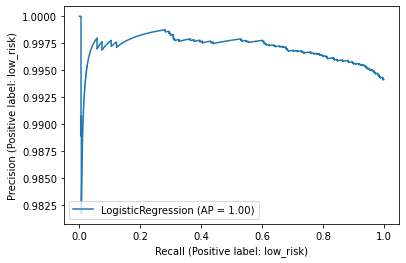

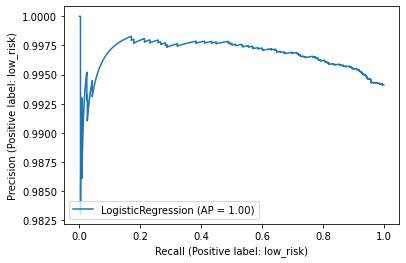

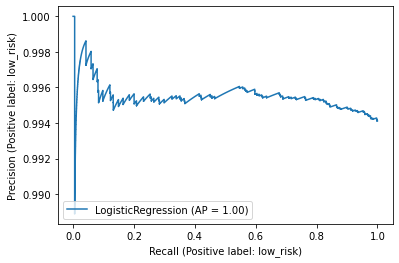

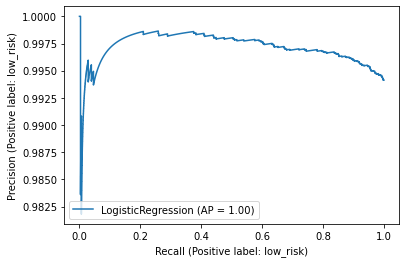

In [43]:
# Using Matplolib create a chart of Precision-Recall Curve
Log_disp = plot_precision_recall_curve(model_log, X_test, y_test)
Smote_disp = plot_precision_recall_curve(model_smote, X_test, y_test)
Under_disp = plot_precision_recall_curve(model_under, X_test, y_test)
Combo_disp = plot_precision_recall_curve(model_combo, X_test, y_test)

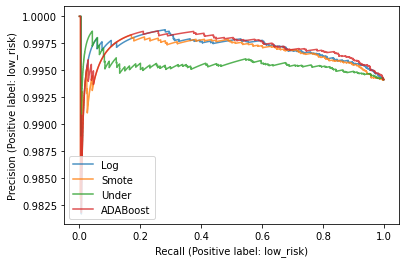

In [44]:
# Put the Precision-Recall Curve in the same axis 
ax = plt.gca()
Log_disp.plot(ax=ax, label='Log',alpha=0.8)
Smote_disp.plot(ax=ax, label='Smote',alpha=0.8)
Under_disp.plot(ax=ax, label='Under', alpha=0.8)
Combo_disp.plot(ax=ax, label='ADABoost',alpha=0.8)